# **Improved cell segmentation using U-net in deep learning**

## Probem Definition

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip show pillow

Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bokeh, dopamine-rl, fastai, imageio, imgaug, matplotlib, scikit-image, torchvision, wordcloud


In [3]:
!pip install pandas_read_xml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 9.5 MB/s eta 0:00:00


In [4]:
# Import libries
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import pandas_read_xml as pdx
from pandas_read_xml import flatten

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU



In [5]:
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
      try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

In [6]:
setup_gpu()

In [9]:

# Set the path to the directory containing your dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/allfilesproject2023/Original Dataset/'

file_names = os.listdir(dataset_dir)
#print(type(file_names))
print(len(file_names))

3512


## Build the Dataset

In [ ]:
# List of files
files = file_names

# Empty lists to hold png and xml files
png_files = []
xml_files = []

# Loop through the list of files
for file in files:
    # Check if the file ends with '.png'
    if file.endswith('.png'):
        png_files.append(file)
    # Check if the file ends with '.xml'
    elif file.endswith('.xml'):
        xml_files.append(file)

# Sort the png and xml files list
png_files.sort()
xml_files.sort()


print("PNG Files:", len(png_files))
print("XML Files:", len(xml_files))


PNG Files: 1756
XML Files: 1756


In [ ]:
value = png_files[40]

value

'b (633).png'

In [ ]:
xml_files[40]

'b (633).xml'

In [ ]:
if (value.split(".")[0] + ".xml") in xml_files:
    print("The value is in the list.")
else:
    print("The value is not in the list.")

The value is in the list.


Visualize the Image file and corresponding xml file

(219, 225)


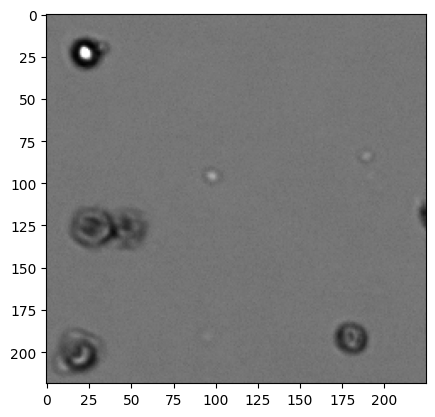

In [ ]:
img = cv2.imread(os.path.join(dataset_dir, png_files[40]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img,cmap='gray') #BMP IS IMAGE, PNG IS MASK

In [ ]:
p_img = cv2.resize(img,(128,128))

p_img.shape

(128, 128)

In [10]:

###############################
# Define the function to load and preprocess the dataset


def load_dataset():
  file_names = os.listdir(dataset_dir)
  num_samples = len(file_names)
  images = []
  masks = []
  total_cell = {}

  # Empty lists to hold png and xml files
  png_files = []
  xml_files = []
  files = file_names

  # Loop through the list of files
  for file in files:
    # Check if the file ends with '.png'
    if file.endswith('.png'):
      png_files.append(file)
    # Check if the file ends with '.xml'
    elif file.endswith('.xml'):
      xml_files.append(file)

  # Sort the png and xml files list
  png_files.sort()
  xml_files.sort()

  #print("PNG Files:", len(png_files))
  #print("XML Files:", len(xml_files))

  # Define the number of dead and living cells
  living_cell = 0
  dead_cell = 0

  # Normalize the bounding box coordinates
  normalized_bounding_boxes = []

  ##############################
  for i in range(len(png_files)):
    file_path_img = os.path.join(dataset_dir, png_files[i])
    file_path_mask = os.path.join(dataset_dir, xml_files[i])

    # Load the image and mask using PIL or any other library suitable for your dataset
    # Preprocess the image and mask as needed (e.g., resizing, normalization)


    # Convert the image to a NumPy array
    image = cv2.imread(file_path_img)
    image = Image.fromarray(image)
    image = image.resize((128, 128))
    # Preprocess the image (resize, normalize) as needed
    # image = cv2.resize(image, (128, 128))
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1] if necessary

    # Load the mask using the pandas read xml library
    # Load the XML mask file
    tree = ET.parse(file_path_mask)
    root = tree.getroot()
    #root = pdx.read_xml(os.path.join(dataset_dir, file_path_mask))
    #root = root.pipe(flatten)

    # Create an empty mask with the same shape as the image
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)


    # Iterate through XML elements to extract bounding box coordinates
    for obj in root.findall('.//object'):
      class_name = obj.find('name').text
      if class_name == 'Living Cell':
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 1

        # Increment the living cell
        living_cell += 1
      elif class_name == 'Dead Cell':
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Set the region defined by the bounding box to 1 in the mask
        mask[ymin:ymax, xmin:xmax] = 2

        # Increment the dead cell
        dead_cell += 1




    images.append(image)
    masks.append(mask)
    total_cell['living_cell'] = living_cell
    total_cell['dead_cell'] = dead_cell

  return np.array(images), np.array(masks), total_cell



In [11]:
# Load the dataset
images, masks, cell_ratio = load_dataset()

# Print the shape of the loaded dataset to verify correctness
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (1756, 128, 128, 3)
Masks shape: (1756, 128, 128)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt


#cell_ratio = pd.DataFrame(cell_ratio, index = True)
cell_ratio

{'living_cell': 4798, 'dead_cell': 1075}

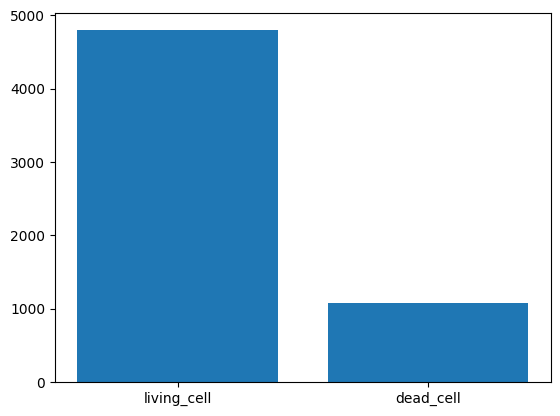

In [11]:
plt.bar(cell_ratio.keys(), cell_ratio.values())
plt.show()

## Build the Model

In [12]:
####################
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate


def unet_model(input_shape):
    # Input layer
    inputs = Input(input_shape)

    # Downward path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upward path
    up4 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv3))
    merge4 = Concatenate()([conv2, up4])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge5 = Concatenate()([conv1, up5])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model




In [13]:
# Create the model
#input_shape = (128, 128, 3)  # Adjust the input shape according to your images
input_shape = images[0].shape
model = unet_model(input_shape)

This implementation follows the U-Net architecture with skip connections.

## Model Training

Now, we'll train the U-Net model using the prepared training dataset.

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)

# Normalize pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = y_train / 255.0
y_test = y_test / 255.0

In [ ]:
y_train.shape

(1229, 128, 128)

In [15]:
# Compile the model
#model.compile(optimizer='adam', loss=combined_loss(y_train, y_test), metrics=['accuracy', , MeanIoU(num_classes=2, name='IoU')])

model.compile(optimizer=Adam(), loss='binary_crossentropy', \
              metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [17]:
# Config Training
BATCH_SIZE = 15
SPE = len(X_train) // BATCH_SIZE

# Training
results = model.fit(
    X_train, y_train,
    validation_split=0.5,
    epochs=5,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE

)


Epoch 1/5
81/81 [==============================] - 1413s 17s/step - loss: 0.0467 - accuracy: 0.9553 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000
Epoch 2/5
81/81 [==============================] - 1387s 17s/step - loss: 0.0024 - accuracy: 0.9674 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000
Epoch 3/5
43/81 [==============>...............] - ETA: 9:26 - loss: 0.0024 - accuracy: 0.9678 - IoU: 1.0000

81/81 [==============================] - 843s 10s/step - loss: 0.0024 - accuracy: 0.9678 - IoU: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9657 - val_IoU: 1.0000


In [ ]:
# Train the model
result = model.fit(X_train, y_train, batch_size=10, epochs=5)  # Adjust batch size and number of epochs as needed



In [18]:
# Save the trained model
model.save('/content/drive/MyDrive/allfilesproject2023/cell_segmentation_model_improved.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/allfilesproject2023/Cell_Segmentation_Model.h5')



## Model Evaluation

Finally, we'll evaluate the trained model using the testing dataset.

In [7]:
# Step 4: Model Evaluation
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/allfilesproject2023/cell_segmentation_model_improved.h5')

#model_1 = load_model('/content/drive/MyDrive/allfilesproject2023/Cell_Segmentation_Model.h5')




In [13]:
# Evaluate the model
loss, accuracy, result = model.evaluate(X_test, y_test)

# Perform segmentation on test images
predicted_masks_ = model.predict(X_test)


17/17 [==============================] - 159s 9s/step


In [14]:
# Obtain the predicted class labels
y_pred = np.argmax(predicted_masks_, axis=-1)

Basic implementation of an improved cell segmentation program using U-Net in deep learning.

Experiment it with different model architectures, loss functions, and hyperparameters to further improve the segmentation accuracy.

In [25]:
import matplotlib.pyplot as plt

# Visualize the segmentation results and compare with ground truth labels
def visualize_segmentation_results(images, masks, predicted_masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_masks[i], cmap='gray')
        axes[i, 2].set_title('Predicted')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have loaded the test images (X_test), ground truth masks (y_test), and predicted masks (predicted_masks)




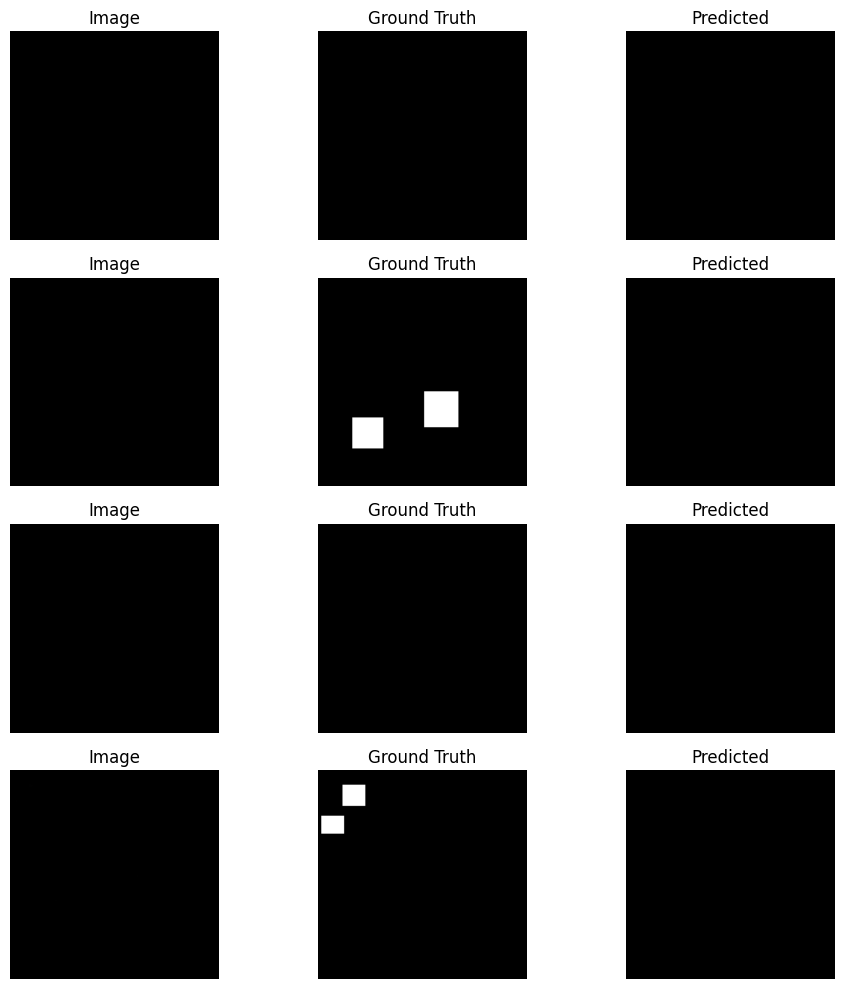

In [26]:
# Select a few random samples for visualization
num_samples = 4
indices = np.random.choice(len(X_test), num_samples, replace=False)

sample_images = X_test[indices]
sample_masks = y_test[indices]
sample_predicted_masks = predicted_masks_[indices]

# Visualize the segmentation results
visualize_segmentation_results(sample_images, sample_masks, sample_predicted_masks)

In [20]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

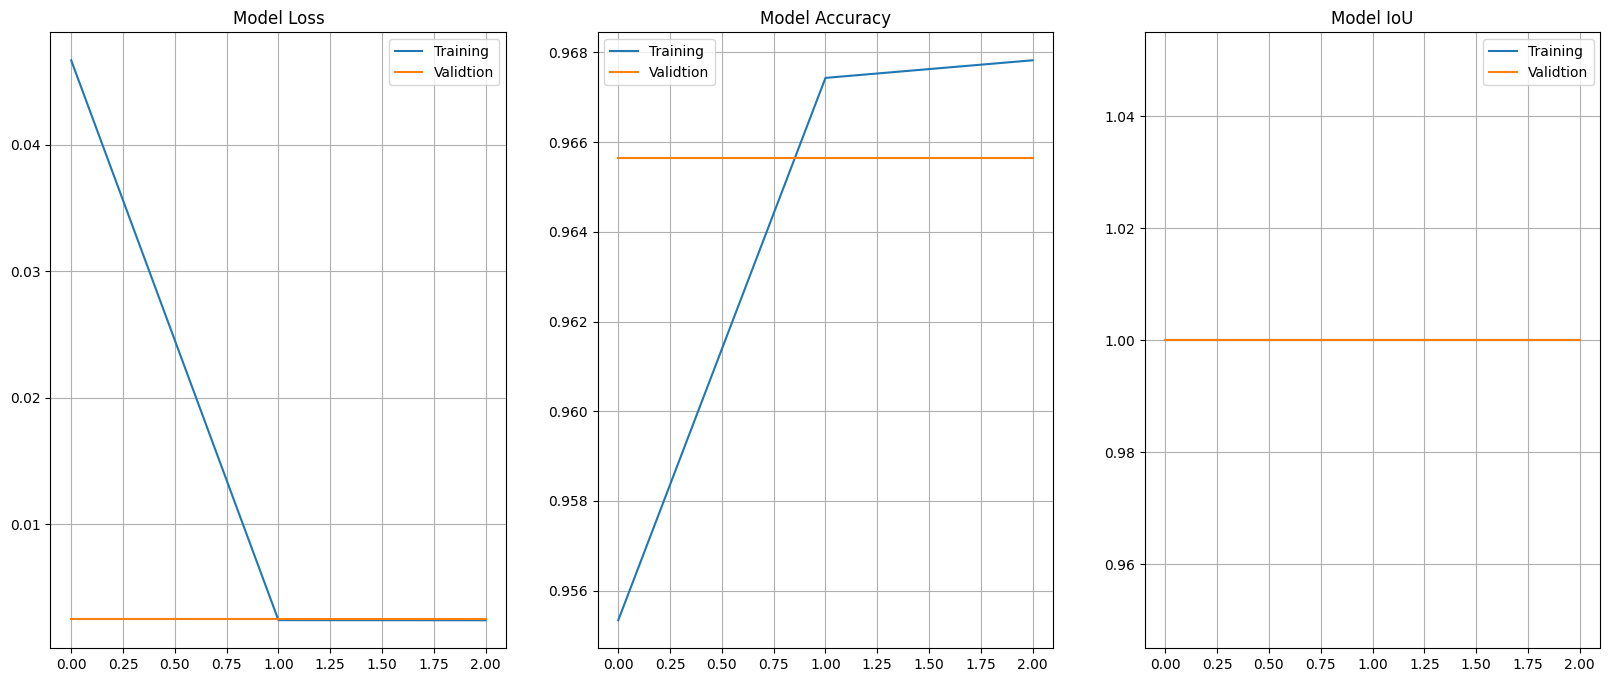

In [21]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [27]:
def show_mask(image, mask, cmap=None, alpha=0.4):

    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

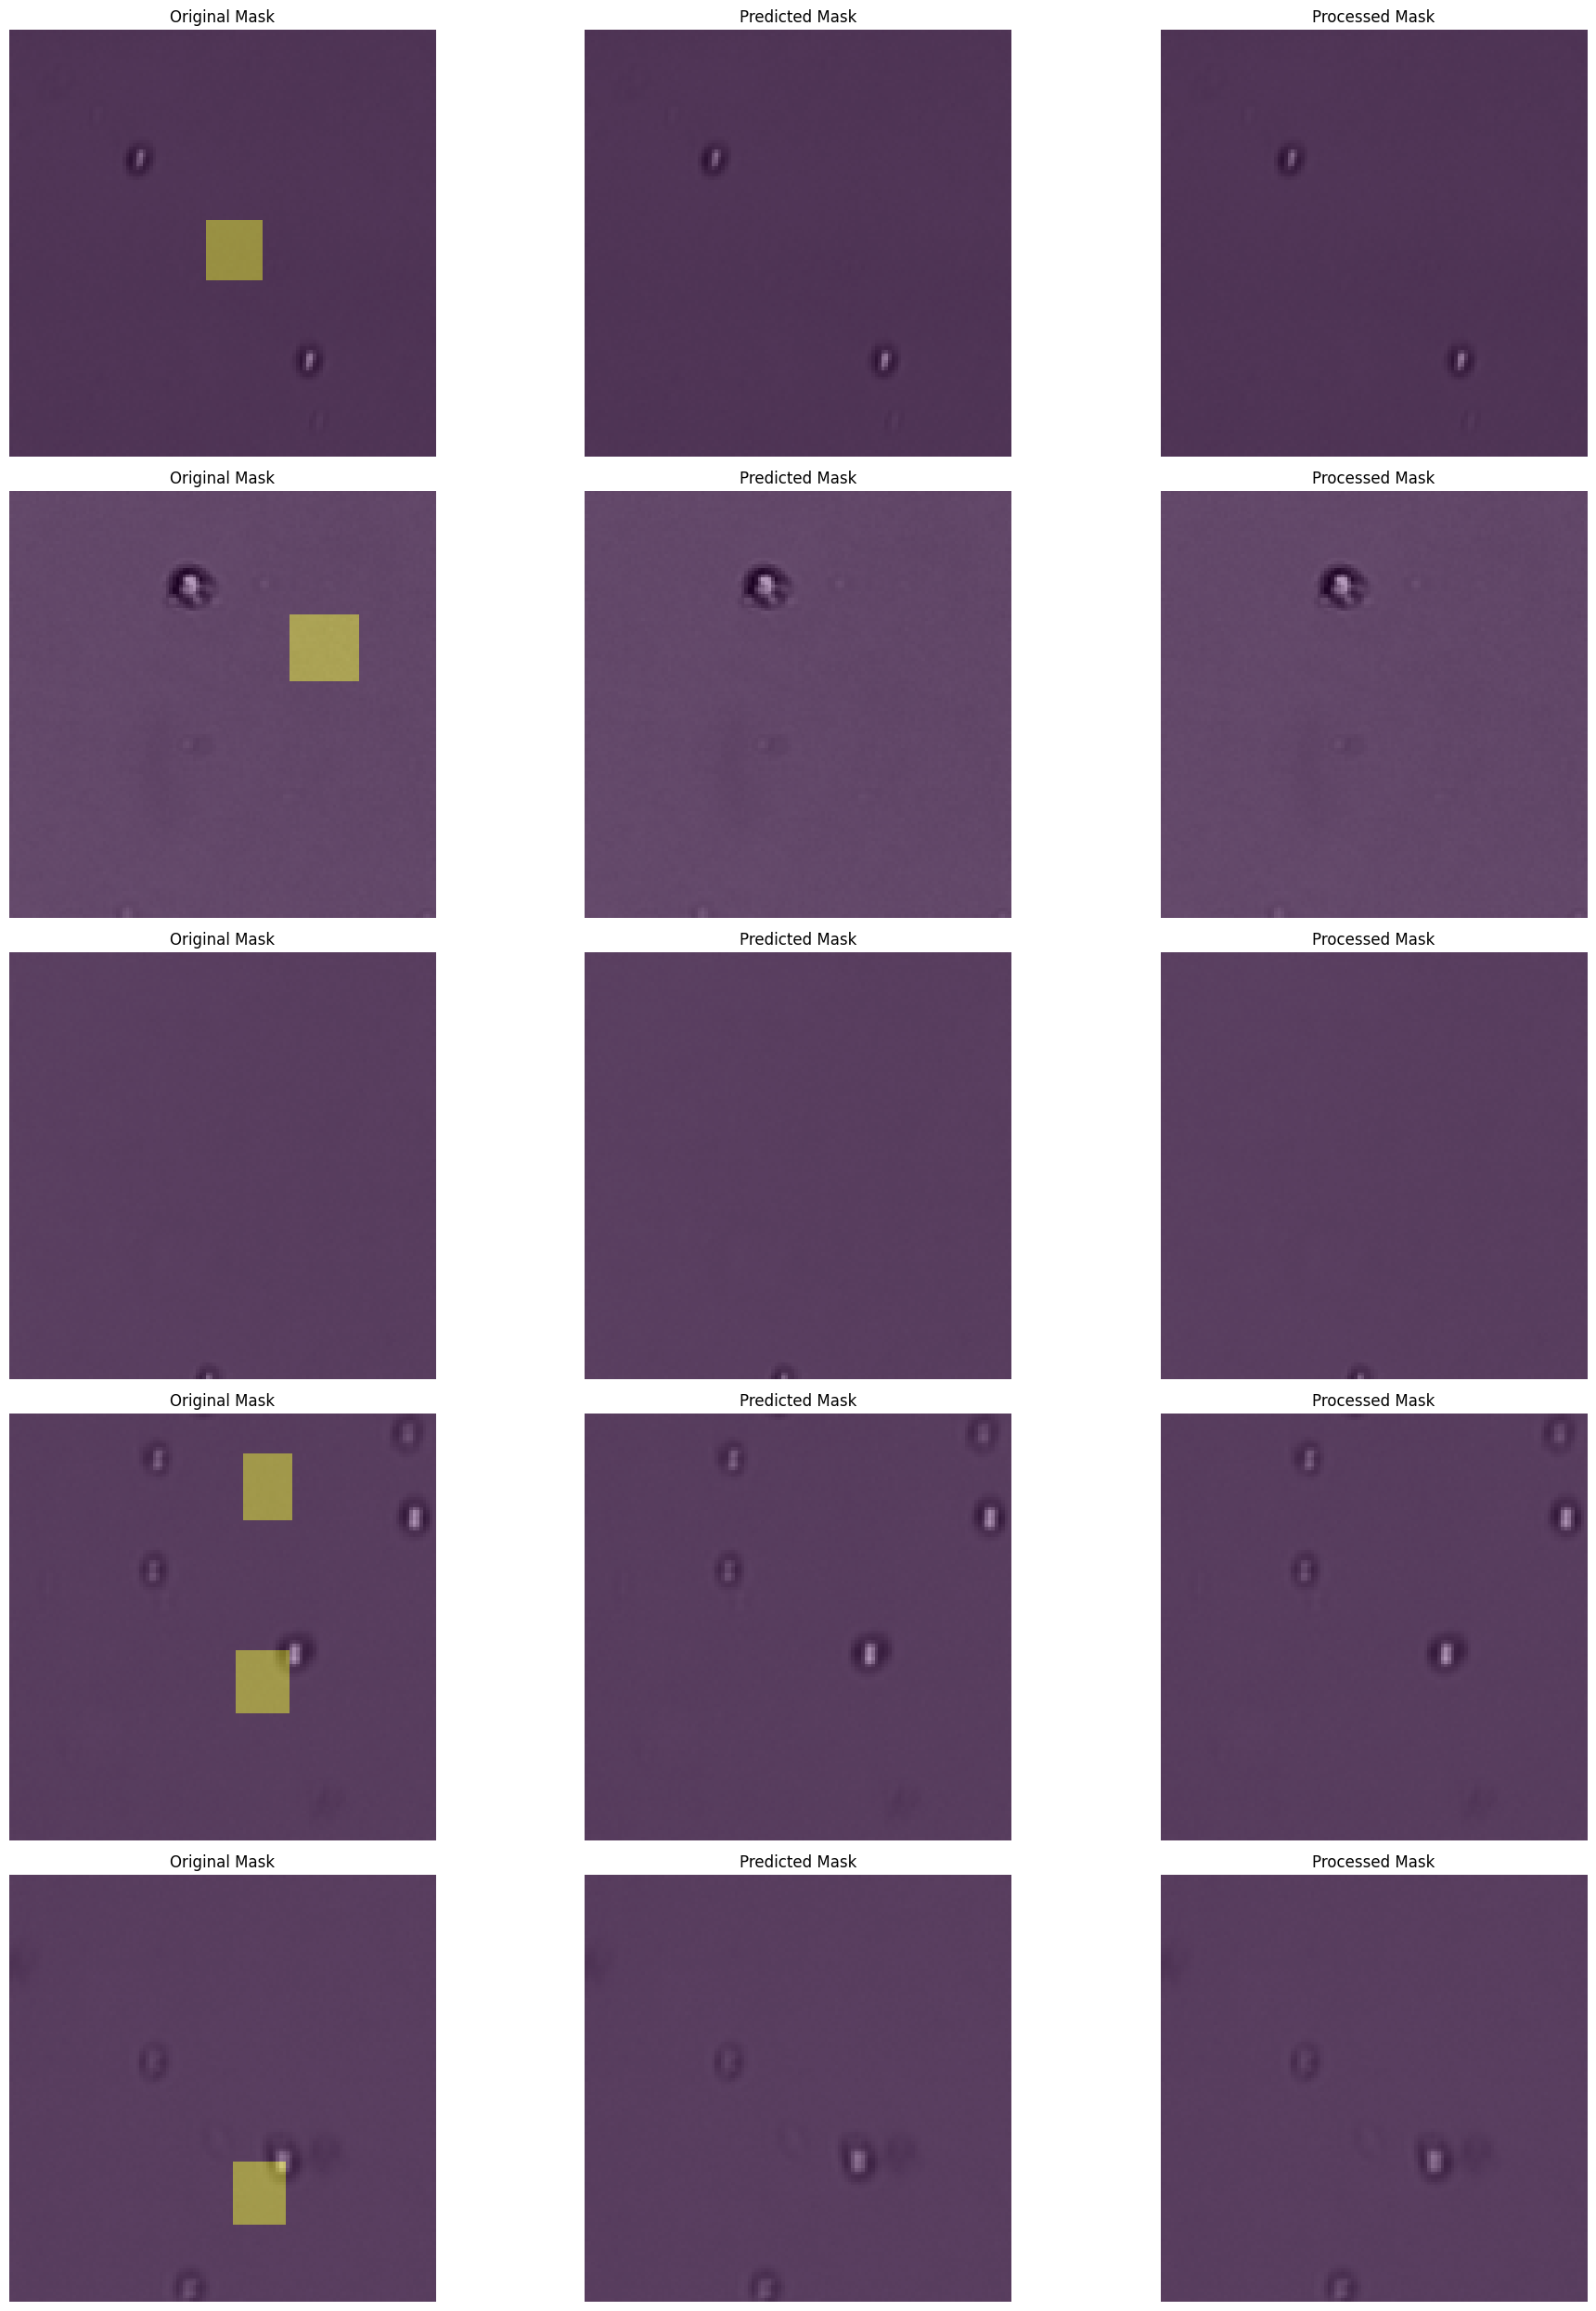

In [30]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(predicted_masks_))
        image = images[id]
        mask = masks[id]
        pred_mask = predicted_masks_[id]

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true is the true binary mask and y_pred is the predicted mask
# both have shape (num_samples, height, width, num_channels)
#y_true = y_val
#y_pred = model.predict(X_val)



# threshold the predicted mask to convert to binary values
y_true_bool = (y_test > 0.5).astype(bool)
cm = confusion_matrix(y_true_bool.flatten(), predicted_masks_.flatten())
cr = classification_report(y_true_bool.flatten(), predicted_masks_.flatten())

print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Confusion matrix:
[[8634368]]
Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   8634368

    accuracy                           1.00   8634368
   macro avg       1.00      1.00      1.00   8634368
weighted avg       1.00      1.00      1.00   8634368



In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

# Assuming '1' represents dead cells (minority class)
minority_class = 2

# Reshape your ground truth labels and predictions into 1D arrays
y_test = y_test.reshape(-1)
y_pred = predicted_masks_.reshape(-1)

# Binarize predictions
y_pred_bin = (y_pred > 0.5).astype(int)

# Calculate F1-score for the minority class
f1 = f1_score(y_test, y_pred_bin, pos_label=minority_class)
print(f'F1-score: {f1}')

# Calculate ROC AUC for the minority class
roc_auc = roc_auc_score(y_test == minority_class, y_pred)
print(f'ROC AUC: {roc_auc}')


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# Assuming y_true contains the true labels (ground truth) and y_pred contains the predicted labels
# Replace y_true and y_pred with your actual data

# Calculate F1-score for the minority class ("dead" cells)
f1_score_dead_cells = f1_score(y_test, y_pred, pos_label=2)  # Assuming "2" represents "dead" cells

# Calculate ROC AUC score for the minority class ("dead" cells)
roc_auc_score_dead_cells = roc_auc_score(y_test == 2, predicted_masks_[:, 2])  # Assuming "2" represents "dead" cells

# You can also calculate the ROC curve if needed
fpr, tpr, thresholds = roc_curve(y_true == 2, predicted_masks_[:, 2])  # ROC curve for "dead" cells

print("F1-Score for Dead Cells:", f1_score_dead_cells)
print("ROC AUC Score for Dead Cells:", roc_auc_score_dead_cells)
